In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('/content/17flowerdataset.zip', 'r') as zip_ref:
       zip_ref.extractall('/content/17flowerdataset')

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os


In [ ]:
data_dir = '/content/17flowerdataset'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input_folder = '/content/17flowerdataset/17FlowerOxfordDataset'  # Assuming images are in 'jpg' folder
output_folder = '/content/17flowerdataset/data' # Create a new folder for train/test

splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2))
# If you have 'split_folders' (older version):
# split_folders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2))

# Set the data directory to the new output folder
data_dir = output_folder

Copying files: 1360 files [00:00, 2308.62 files/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


In [ ]:
trainset =ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
testset = ImageFolder(os.path.join(data_dir, 'val'), transform=transform)  # Changed 'test' to 'val'

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjusted the input size for fc1
        self.fc2 = nn.Linear(128, 17) # Changed the output size to 17 (number of flower types)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 56 * 56)  # Adjusted the view to match the output size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, trainloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # CNN outputs (logits)


            print(f"Logits for first image in batch: {outputs[0]}")  # First image in the batch

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}")

train(model, trainloader, criterion, optimizer)

Logits for first image in batch: tensor([ 0.0335, -0.0245, -0.0331, -0.0311,  0.0063,  0.0548,  0.0073, -0.0418,
        -0.0184, -0.0109, -0.0829,  0.0589,  0.0484, -0.0863,  0.0861, -0.0516,
         0.0159], grad_fn=<SelectBackward0>)
Logits for first image in batch: tensor([-1.7004,  0.6084,  0.9880,  0.2958,  3.7308,  1.1591,  4.8816,  1.9356,
        -7.3312, -2.2975,  0.2483, -2.9583,  0.5968, -1.6323,  0.9099, -6.9405,
        -3.0739], grad_fn=<SelectBackward0>)
Logits for first image in batch: tensor([ 1.7470,  2.0669,  1.9153,  2.8789, -1.4573,  2.1149, -3.1782,  2.7470,
        -6.4534,  3.1075,  4.5688, -3.0746,  1.2224, -1.1703,  3.4130, -7.3087,
        -3.6693], grad_fn=<SelectBackward0>)
Logits for first image in batch: tensor([ 2.1063,  3.3958,  2.8687,  2.9669, -2.5228,  1.7214, -4.7948,  3.3371,
        -6.5129,  3.9564,  1.0373, -1.7495,  0.8605, -1.0268,  2.9484, -8.4987,
        -3.6781], grad_fn=<SelectBackward0>)
Logits for first image in batch: tensor([ 3.7815

In [ ]:
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images)  # CNN outputs (logits)

            # Print CNN outputs (logits) for the first image in each batch
            print(f"Logits for first image in batch: {outputs[0]}")  # This will print the logits for the first image

            features.extend(outputs.cpu().numpy())  # Extract CNN outputs as features
            labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(model, trainloader)
X_test, y_test = extract_features(model, testloader)

Logits for first image in batch: tensor([ -4.7765,   1.6813,   3.3104,  -3.5583,   2.7027,  -0.6585,   4.9766,
         -3.5010,   3.0608,  -2.1000,  -1.2646,   5.4057,   2.9757,   4.4207,
         -6.0143,  -9.9820, -10.1235])
Logits for first image in batch: tensor([  1.7304,  -1.6545,  -0.5939,   2.0849,   0.5996,   6.1725,  -2.2682,
          1.0660,   0.5067,   2.3103,   3.9666,  -5.9807,   0.3667,   0.2924,
          7.2512, -10.7790,  -5.7466])
Logits for first image in batch: tensor([-1.6111,  1.4446,  1.5435, -1.6905,  3.1278,  1.2020,  0.6463, -1.8486,
         1.4010, -0.5415, -0.9244, -1.8342,  0.9248,  2.2675, -1.1131, -6.0442,
        -5.1017])
Logits for first image in batch: tensor([-4.3349,  3.0799,  1.8821, -3.2398,  4.9778,  0.8292,  3.4317, -3.6440,
         2.0900, -1.6086, -4.0872, -1.6684,  0.8567,  4.8350, -3.7806, -9.5678,
        -9.0490])
Logits for first image in batch: tensor([ 2.9863, -1.1521, -0.5529,  2.0175, -0.7950, -0.9356, -3.5801,  2.0273,
         

In [ ]:
dt = DecisionTreeClassifier(max_depth=5)  # Decision Tree model
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
acc = dt.score(X_test, y_test)
print(f"Surrogate Model Accuracy: {acc * 100:.2f}%")

Surrogate Model Accuracy: 37.13%


In [ ]:
!pip install graphviz

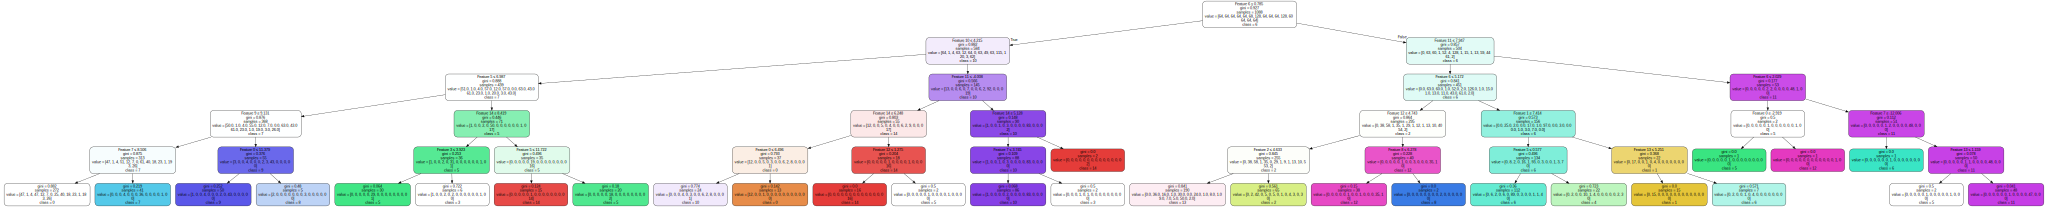

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

def visualize_surrogate_model(dt):
    dot_data = export_graphviz(dt, out_file=None,
                                feature_names=[f"Feature {i}" for i in range(X_train.shape[1])],
                                class_names=[str(i) for i in range(17)],
                                filled=True, rounded=True,
                                special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

visualize_surrogate_model(dt)

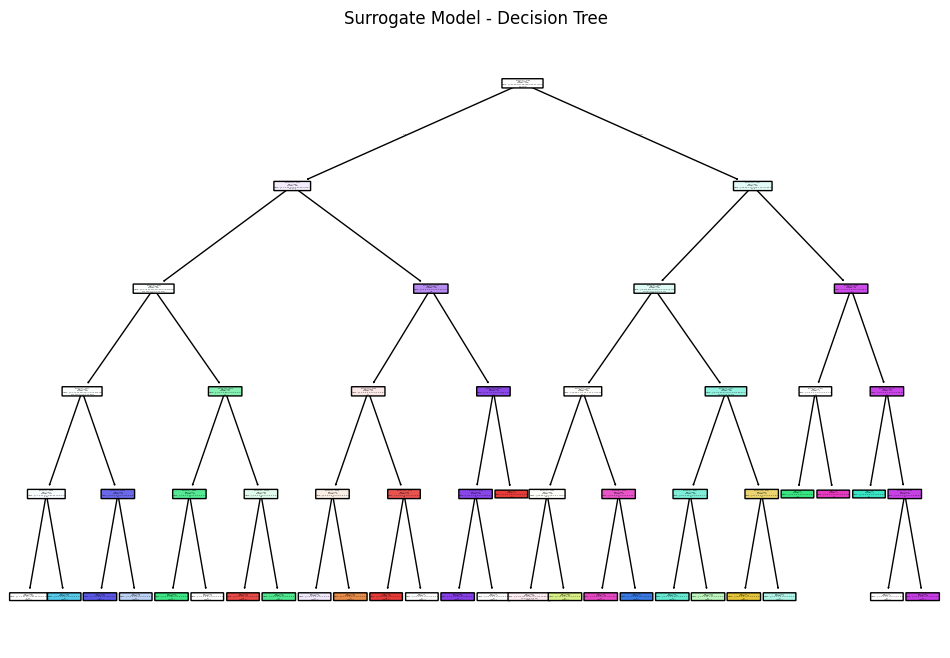

In [ ]:
def visualize_surrogate_model(dt):
    plt.figure(figsize=(12, 8))
    # Changed class_names to include all 17 classes
    plot_tree(dt, filled=True, feature_names=[f"Feature {i}" for i in range(X_train.shape[1])],
              class_names=[str(i) for i in range(17)], rounded=True)
    plt.title("Surrogate Model - Decision Tree")
    plt.show()

visualize_surrogate_model(dt)

In [ ]:
def plot_feature_importance(dt, feature_names):
    feature_importances = dt.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances (Surrogate Model)")
    plt.barh(range(X_train.shape[1]), feature_importances[indices], align="center")
    plt.yticks(range(X_train.shape[1]), [f"Feature {i}" for i in indices])
    plt.xlabel("Importance")
    plt.show()

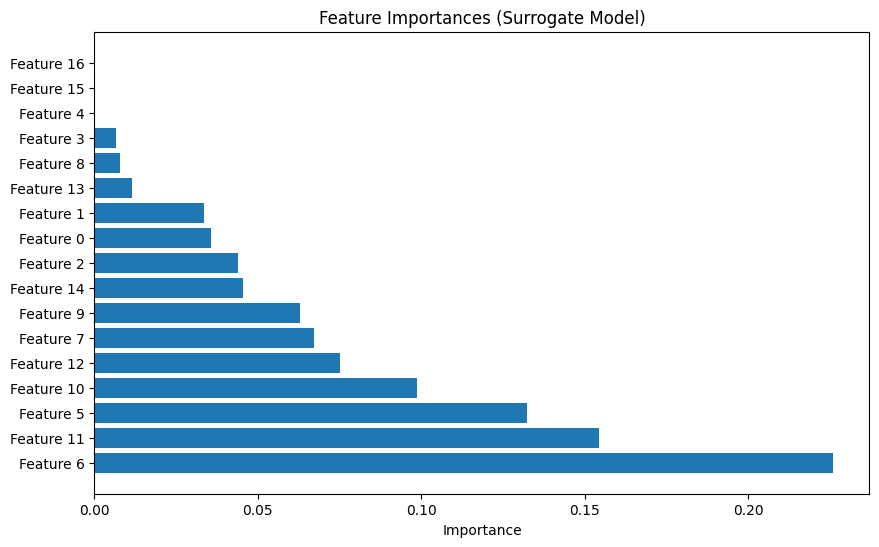

In [ ]:
# Visualizing Feature Importance of the Surrogate Model
plot_feature_importance(dt, [f"Feature {i}" for i in range(X_train.shape[1])])

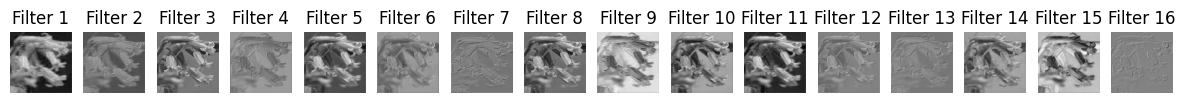

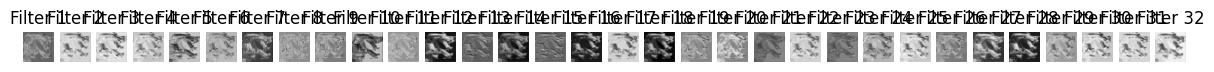

In [ ]:
def visualize_feature_maps(model, input_image):
    model.eval()
    layers = [model.conv1, model.conv2]  # Choose the convolutional layers to visualize
    activations = []

    def save_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    # Register hooks to the convolutional layers
    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(save_activation(layer.__class__.__name__)))

    # Perform a forward pass
    input_image = input_image.unsqueeze(0).to(device)
    model(input_image)

    # Visualize the feature maps
    for i, activation in enumerate(activations):
        activation = activation.squeeze(0).cpu().detach().numpy()
        num_filters = activation.shape[0]

        # Display the feature maps for each filter
        fig, axes = plt.subplots(1, num_filters, figsize=(15, 8))
        for j in range(num_filters):
            axes[j].imshow(activation[j], cmap='gray')
            axes[j].axis('off')
            axes[j].set_title(f"Filter {j + 1}")
        plt.show()

    # Remove hooks after visualization
    for hook in hooks:
        hook.remove()

# Visualize feature maps of the first image in the test set
sample_image, sample_label = testset[0]
visualize_feature_maps(model, sample_image)


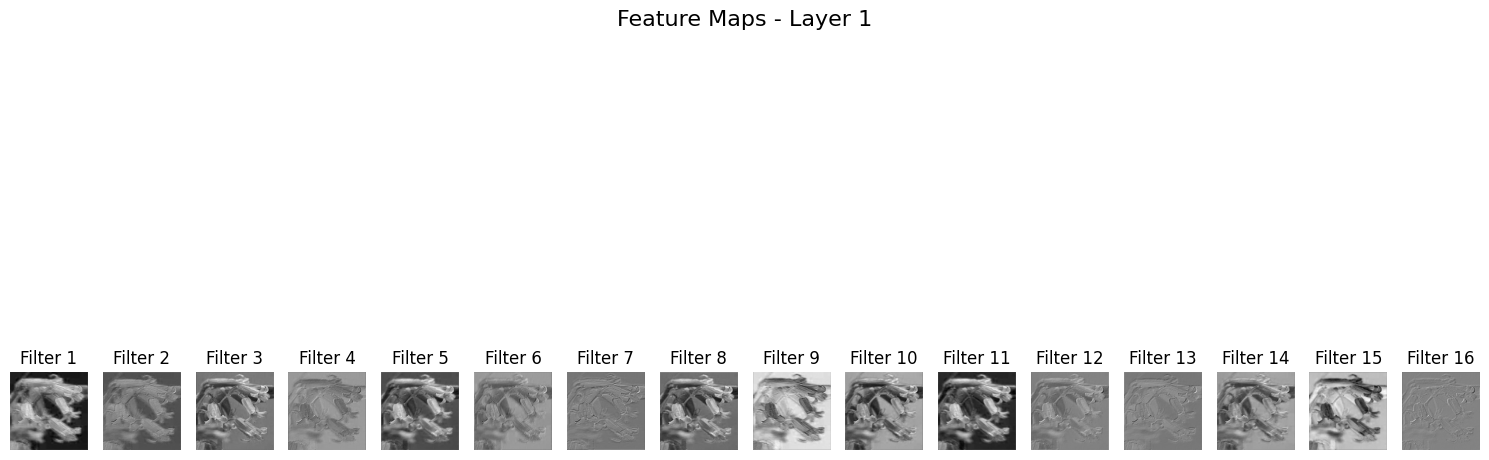

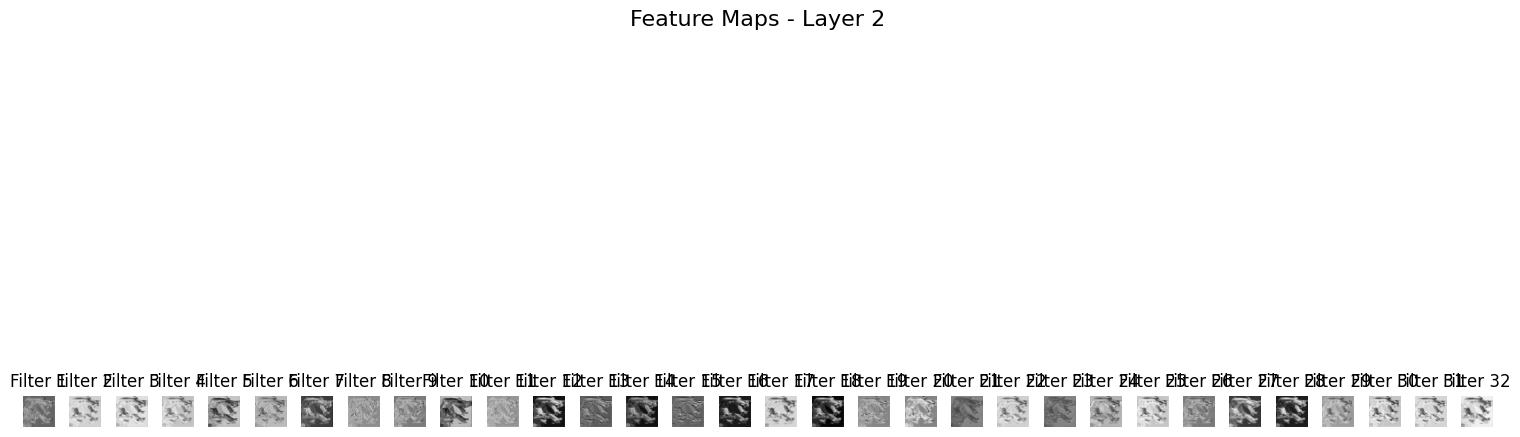

In [ ]:
def visualize_feature_maps(model, input_image):
    model.eval()
    layers = [model.conv1, model.conv2]
    activations = []

    def save_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(save_activation(layer.__class__.__name__)))

    input_image = input_image.unsqueeze(0).to(device)
    model(input_image)

    # Create a single figure and axes for all feature maps of a layer
    for i, activation in enumerate(activations):
        activation = activation.squeeze(0).cpu().detach().numpy()
        num_filters = activation.shape[0]

        fig, axes = plt.subplots(1, num_filters, figsize=(15, 8))
        fig.suptitle(f"Feature Maps - Layer {i + 1}", fontsize=16) # Add layer title

        for j in range(num_filters):
            axes[j].imshow(activation[j], cmap='gray')
            axes[j].axis('off')
            axes[j].set_title(f"Filter {j + 1}")

        plt.tight_layout() # Adjust subplot parameters for a tight layout
        plt.show() # Show the figure for the current layer

    for hook in hooks:
        hook.remove()

# Visualize feature maps of the first image in the test set
sample_image, sample_label = testset[0]
visualize_feature_maps(model, sample_image)